In [ ]:
!pip install pandas
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
file_path = "/content/drive/My Drive/Score.xlsx"
df = pd.read_excel(file_path)
df


Mounted at /content/drive


,Chromosome,Position,Score
0,2L,3745921,0.056492
1,2L,3745922,0.054833
2,2L,3745923,0.072352
3,2L,3745924,0.049789
4,2L,3745925,0.194774
...,...,...,...
1626,2L,3747547,0.007022
1627,2L,3747548,0.002024
1628,2L,3747549,0.030302
1629,2L,3747550,0.008787


Text(0, 0.5, 'Score')

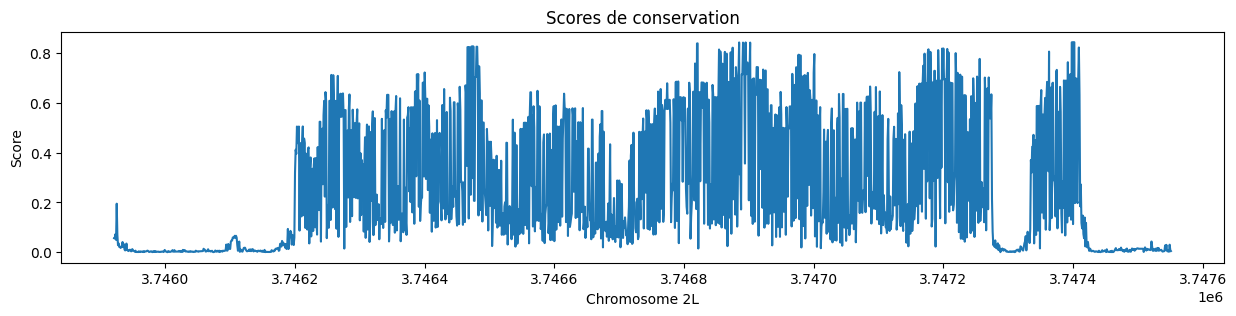

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 3))
plt.gca().set_facecolor('none')
plt.plot(df['Position'], df['Score'])
plt.title('Scores de conservation')
plt.xlabel('Chromosome 2L')
plt.ylabel('Score')